# Scoring correlation

## Explanation

This notebook can be used to visualize and quantify the difference between DCA, ESM, and true protein structure outputs.

## Setup

### Imports

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, zscore
from scipy.ndimage import gaussian_filter
import sys
sys.path.append('..')
from utils.esm_true_structure_inference import precision_at_k
import seaborn as sns
real_contacts_path = os.path.join('..', 'data', 'cadherin', 'PF00028_real_contacts.csv')
contacts = np.loadtxt(real_contacts_path, delimiter=",")

### Helper functions

In [2]:
vmin, vmax = 0, 1
SYMMETRIC = True
# Filter predictions that are greater than "dist" and then take the top L
def filter_L(df:pd.DataFrame, L=None, dist:int=4):
    return df[df.apply(lambda df: df["i"] + dist < df["j"], axis=1)][:L].reset_index(drop=True)


def get_matches(df_a, df_b):
    df_a["ij"] = df_a["i"].astype(str) + " " + df_a["j"].astype(str)
    df_b["ij"] = df_b["i"].astype(str) + " " + df_b["j"].astype(str)
    df_dual = pd.merge(df_a, 
                    df_b,
                    how = 'inner',
                    on = 'ij',
                    suffixes=("_a","_b"))
    return df_dual[["prob_a", "prob_b"]]

# create dataframe of ranked pairs from ESM contact matrix
def df_from_esm_contact_matrix(contact_matrix):
    
    gather = []
    
    # traverse over upper right triangle, exlucding main diagonal
    for i in range(contact_matrix.shape[0]):
        for j in range(0 if SYMMETRIC else i+1, contact_matrix.shape[1]):
            # SANITY check the matrix should be symmetric
            assert contact_matrix[i][j] == contact_matrix[j][i]
            row_dict = dict(
                i = i,
                j = j,
                prob = contact_matrix[i,j]
            )
            
            gather.append(row_dict)

    return pd.DataFrame(gather).sort_values(by='prob', ascending = False)
def data_2d(df, symmetric=SYMMETRIC):
    dim = max(df["i"].max() + 1, df["j"].max() + 1)
    data = np.zeros([dim] * 2)
    for i in range(df.shape[0]):
        data[df['i'][i],df['j'][i]] = df['prob'][i]
        if symmetric:
            data[df['j'][i],df['i'][i]] = df['prob'][i]
    return dim, data

def data_padder(dfs):
    dim, datas = 0, []
    for df in dfs:
        new_dim, data = data_2d(df)
        if new_dim > dim:
            dim = new_dim
        datas.append(data)
    returned = []
    for d in datas:
        returned.append(np.pad(d, ((0, dim - d.shape[0]), (0, dim - d.shape[1]))))
    return returned
        

def heatmap_creator(dfs, zscorer=False, smoother=True, smoother_sigma=0.5, paddock=111):
    if type(dfs) == list:
        datas = data_padder(dfs)
        if smoother:
            for i in range(len(datas)):
                datas[i] = gaussian_filter(datas[i], sigma=smoother_sigma)
        data = np.ones_like(datas[0])
        for array in datas:
            data *= abs(array)
            data /= data.max()
    else:
        _, data = data_2d(dfs)
        #if smoother:
        #    data = gaussian_filter(data, sigma=smoother_sigma)
    if paddock:
        data = np.pad(data, ((0, max(paddock - data.shape[0], 0)), (0, max(paddock - data.shape[1], 0))), constant_values=(0))
        
    # Create subplots
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot the first heatmap
    #im1 = ax.imshow(data, cmap='inferno', vmin=vmin, vmax=vmax)
    #ax.set_title("Contact Heatmap")
    if zscorer:
        data = zscore(data,axis=None)
    plt.imshow(data, vmin=data.min(), vmax=data.max())
    plt.colorbar(orientation='vertical', fraction=0.02, pad=0.1)


    # Add a single colorbar
    #cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
    #cbar.set_label("Color Scale")
    #plt.imshow(data) 
    #return data

def comparer(dfs):
    datas = data_padder(dfs)
    data = np.ones_like(datas[0])
    for array in datas:
        data *= array
    return data > 0

def scatter_plotter(df_a, df_a_name, df_b, df_b_name, L=None, xylim="zoomed", line=False):
    matches = get_matches(filter_L(df_a, L=L), filter_L(df_b, L=L))
    plt.scatter(matches["prob_a"], matches["prob_b"])
    if line:
        plt.plot([-1,2],[-1,2],color="black",linestyle="dashed", linewidth=0.5)
    ax = plt.gca()
    if xylim == "zoomed":
        a_min, a_max = matches["prob_a"].min(), matches["prob_a"].max()
        b_min, b_max = matches["prob_b"].min(), matches["prob_b"].max()
        a_range, b_range = (a_max - a_min) / 10, (b_max - b_min) / 10

        ax.set_xlim([a_min - a_range, a_max + a_range])
        ax.set_ylim([b_min - b_range, b_max + b_range])
    elif xylim == "1by1":
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
    plt.xlabel(df_a_name)
    plt.ylabel(df_b_name)
    return matches

## Load data

### Load ESM data

In [3]:
esm_results_path = os.path.join('..', 'results/cadherin/esmfold/results.zip')
esm_results = np.load(esm_results_path)
job_name = 'cadherin'

#number of sequences in Cadherin MSA
num_seqs = 55
#esm_results.keys()
esm_dfs = []
for i in range(num_seqs):
    # index into NPzFile object with file name
    contact_matrix = esm_results[f'{i}_{job_name}']
    df = df_from_esm_contact_matrix(contact_matrix)
    esm_dfs.append(df)
    
for i in range(len(esm_dfs)):
    esm_dfs[i] = df.sort_values(by="prob", ascending=False).reset_index(drop=True)

### Load True Contacts

In [4]:
real_contacts_path = os.path.join('..', 'data', 'cadherin', 'PF00028_real_contacts.csv')
real_contacts = np.genfromtxt(real_contacts_path,delimiter=',') # import
real_contacts_df = pd.DataFrame(real_contacts).astype(int)
for i in [0,1]:
    real_contacts_df["i" if i==1 else "j"] = real_contacts_df[i].astype(int) # convert to ints
real_contacts_df["prob"] = 1 # rename columns
real_contacts_df = real_contacts_df[["i", "j", "prob"]] # take only reformatted, renamed columns


### Load DCA data

In [5]:
# Load Motherfuckin DCA results 
mfdca_results_path = os.path.join('..', 'data', 'cadherin', 'PF00028_mfdca_mapped.csv')
mfdca_df = pd.read_csv(mfdca_results_path, header=None)[[0,4,5,6]]
mfdca_df["id"] = mfdca_df[0].astype(int)
for i in [4,5]:
    mfdca_df["i" if i==4 else "j"] = mfdca_df[i].astype(int) # convert to ints
mfdca_df["prob"] = mfdca_df[6] # rename columns
mfdca_df = mfdca_df[["id", "i", "j", "prob"]] # take only reformatted, renamed columns
mfdca_df = mfdca_df.sort_values(by="prob", ascending=False).reset_index(drop=True) # sort by descending score and reset index
# Load PLM DCA results
plmdca_results_path = os.path.join('..', 'data', 'cadherin', 'PF00028_plmdca_mapped.csv')
plmdca_df = pd.read_csv(plmdca_results_path, header=None)[[0,4,5,6]]
plmdca_df["id"] = plmdca_df[0].astype(int)
for i in [4,5]:
    plmdca_df["i" if i==4 else "j"] = plmdca_df[i].astype(int) # convert to ints
plmdca_df["prob"] = plmdca_df[6] # rename columns
plmdca_df = plmdca_df[["id", "i", "j", "prob"]] # take only reformatted, renamed columns
plmdca_df = plmdca_df.sort_values(by="prob", ascending=False).reset_index(drop=True) # sort by descending score and reset index

mfdca_df = mfdca_df[mfdca_df["id"] == 0].reset_index(drop=True)
plmdca_df = plmdca_df[plmdca_df["id"] == 0].reset_index(drop=True)

## Process Data

### Take Top L

In [6]:
# replace with whatever L (length of true structure file protein) should actually be
# for the precision@L calculations

# NOTE: these indices are relative to the sequence, not MSA
# NOTE: Make sure indexes line up

top_L_esm = filter_L(esm_dfs[0])
top_L_mf = filter_L(mfdca_df)
top_L_plm = filter_L(plmdca_df)

### Heat maps

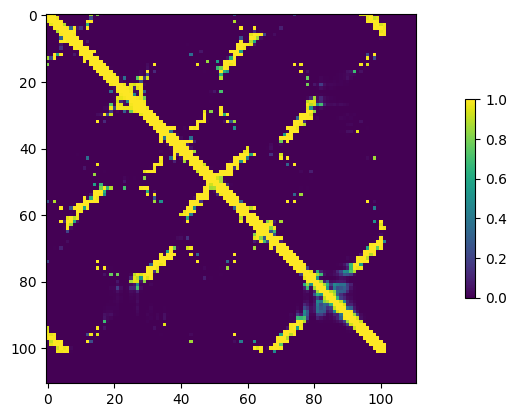

In [7]:
heatmap_creator(esm_dfs[0])
plt.savefig("../plots/heatmaps/esm.png")

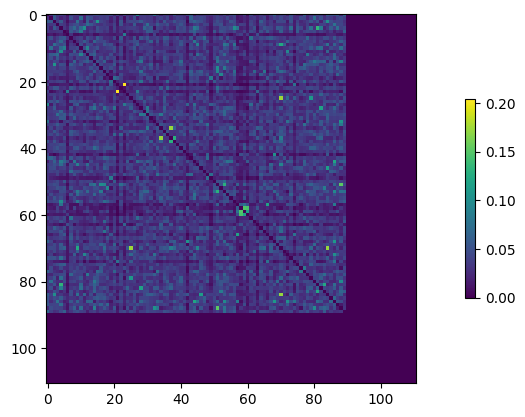

In [8]:
heatmap_creator(mfdca_df)
plt.savefig("../plots/heatmaps/mfdca.png")

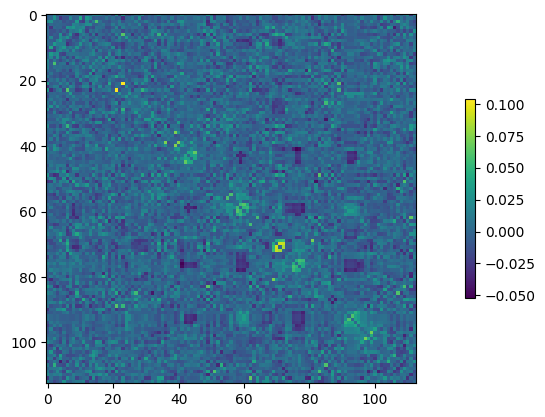

In [9]:
heatmap_creator(plmdca_df)
plt.savefig("../plots/heatmaps/plmdca.png")

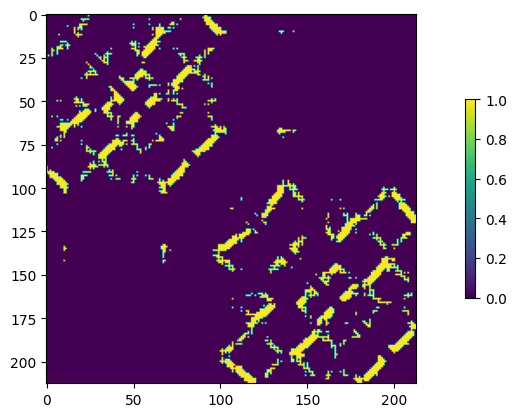

In [10]:
heatmap_creator(real_contacts_df)
plt.savefig("../plots/heatmaps/real_contacts.png")

### Comparisons

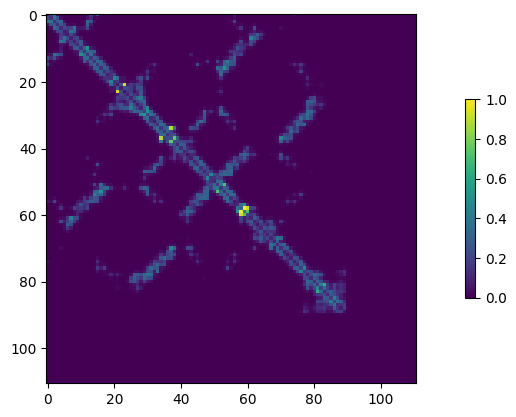

In [11]:
heatmap_creator([esm_dfs[0], mfdca_df])
plt.savefig("../plots/heatmaps/esm-mfdca.png")

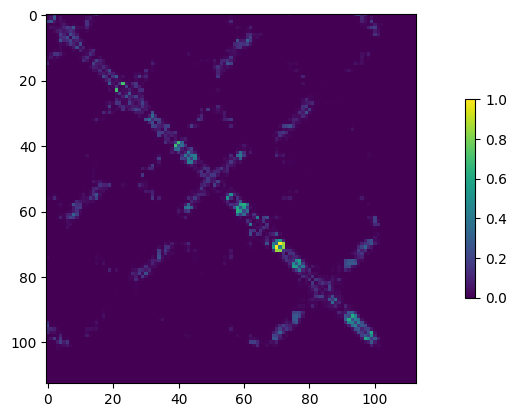

In [12]:
heatmap_creator([esm_dfs[0], plmdca_df])
plt.savefig("../plots/heatmaps/esm-plmdca.png")

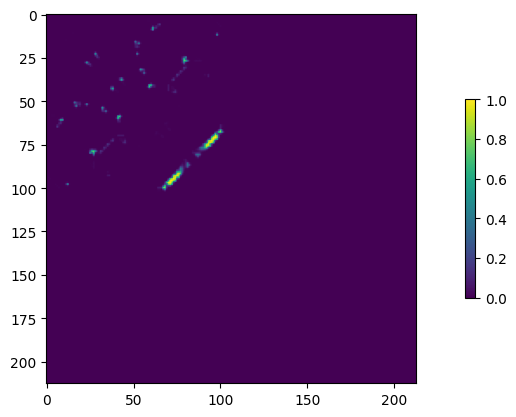

In [13]:
heatmap_creator([esm_dfs[0], real_contacts_df])
plt.savefig("../plots/heatmaps/esm-real_contacts.png")

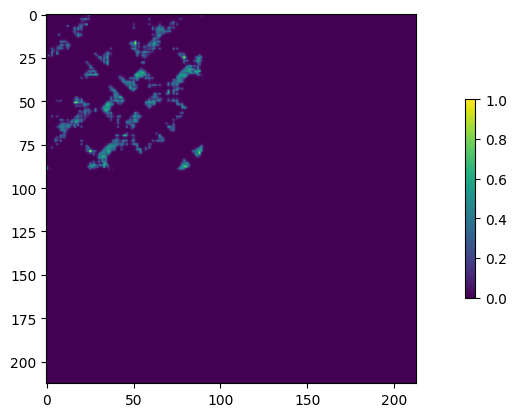

In [14]:
heatmap_creator([real_contacts_df, mfdca_df])
plt.savefig("../plots/heatmaps/mfdca-real_contacts.png")

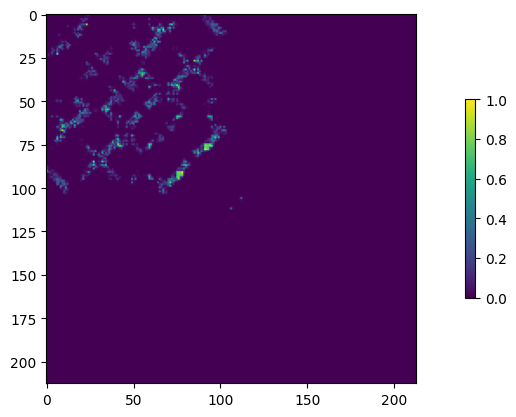

In [15]:
heatmap_creator([real_contacts_df, plmdca_df])
plt.savefig("../plots/heatmaps/plmdca-real_contacts.png")

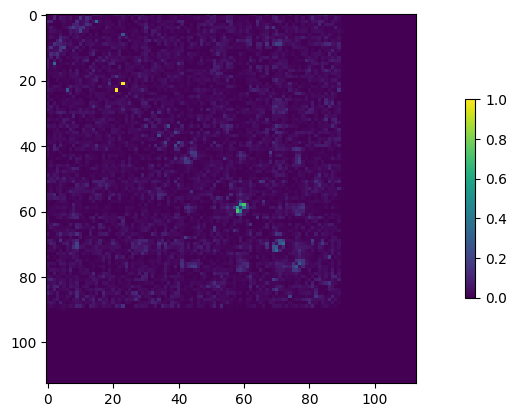

In [16]:
heatmap_creator([plmdca_df, mfdca_df])
plt.savefig("../plots/heatmaps/plmdca-mfdca.png")

### Correlation

(0.07580271217139746, 4.4792413268055e-06)

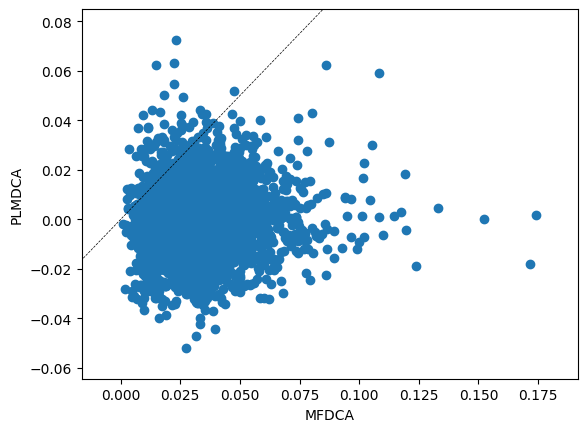

In [17]:
matches = scatter_plotter(mfdca_df, "MFDCA", plmdca_df, "PLMDCA", line=True)
plt.savefig("../plots/scatter_scores/mfdca_plmdca.png")
corr, p = spearmanr(matches["prob_a"], matches["prob_b"])
corr, p

(0.06462180115949034, 9.24626904088715e-05)

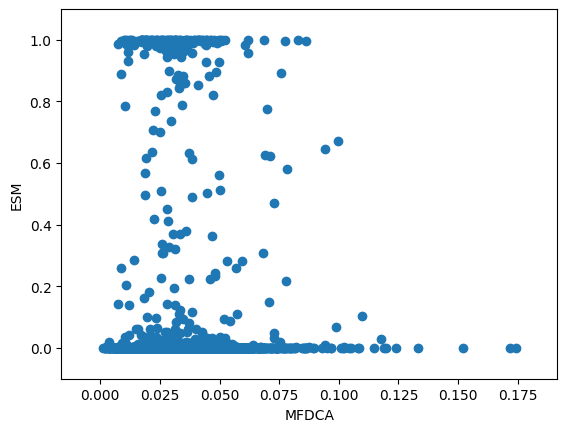

In [18]:
matches = scatter_plotter(mfdca_df, "MFDCA", esm_dfs[0], "ESM")
plt.savefig("../plots/scatter_scores/esm_mfdca.png")
corr, p = spearmanr(matches["prob_a"], matches["prob_b"])
corr, p

(-0.13013395457192778, 0.19460558253306173)

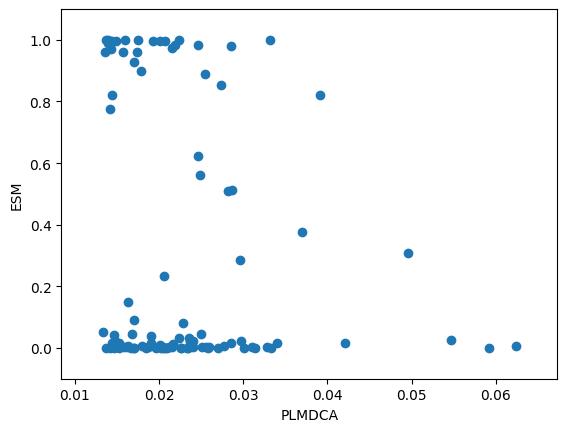

In [19]:
matches = scatter_plotter(plmdca_df, "PLMDCA", esm_dfs[0], "ESM", L=800)
plt.savefig("../plots/scatter_scores/plmdca_esm.png")
corr, p = spearmanr(matches["prob_a"], matches["prob_b"])
corr, p

In [22]:
plmdca_df.shape[0]

6328

<Axes: >

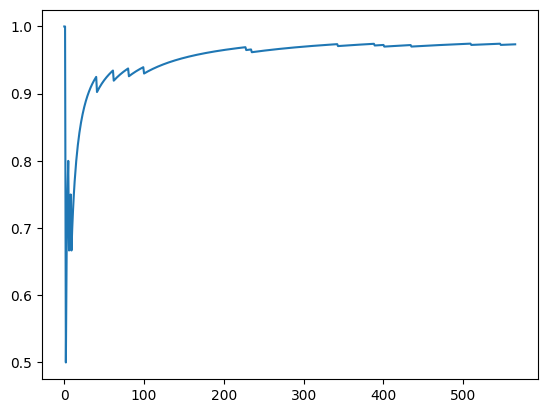

In [29]:
# precision @ L

L, plm_2d = data_2d(plmdca_df)
plmdca_pl = np.ones([1+L*5])
for k in range(1, plmdca_pl.shape[0]):
    plmdca_pl[k]=precision_at_k(plm_2d, contacts, k)
np.save("../data/cadherin/PF00028_plmdca_pl.npy", plmdca_pl)
sns.lineplot(plmdca_pl)

<Axes: >

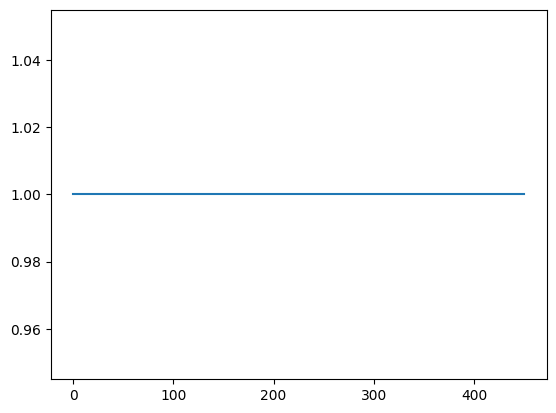

In [30]:
L, mf_2d = data_2d(mfdca_df)
mfdca_pl = np.ones([1+L*5])
for k in range(1, mfdca_pl.shape[0]):
    mfdca_pl[k]=precision_at_k(mf_2d, contacts, k)
np.save("../data/cadherin/PF00028_mfdca_pl.npy", mfdca_pl)
sns.lineplot(mfdca_pl)

In [57]:
import pickle
with open("../data/cadherin/PF00028_pairwise_dists.pkl", "rb") as file:
    pairwise_dists = pickle.load(file)
pairwise_dists_and_plm = {}
pairwise_dists_and_mf = {}
for key in pairwise_dists:
    pairwise_dists_and_plm[key] = {}
    pairwise_dists_and_plm[key]["dist"] = pairwise_dists[key]
    try:
        pairwise_dists_and_plm[key]["score"] = plm_2d[*key]
    except:
        pairwise_dists_and_plm[key]["score"] = -1
plm_dist_score = np.array([[pairwise_dists_and_plm[a]['dist'], pairwise_dists_and_plm[a]['score']] for a in pairwise_dists_and_plm])
for key in pairwise_dists:
    pairwise_dists_and_mf[key] = {}
    pairwise_dists_and_mf[key]["dist"] = pairwise_dists[key]
    try:
        pairwise_dists_and_mf[key]["score"] = mf_2d[*key]
    except:
        pairwise_dists_and_mf[key]["score"] = -1
mf_dist_score = np.array([[pairwise_dists_and_mf[a]['dist'], pairwise_dists_and_mf[a]['score']] for a in pairwise_dists_and_mf])

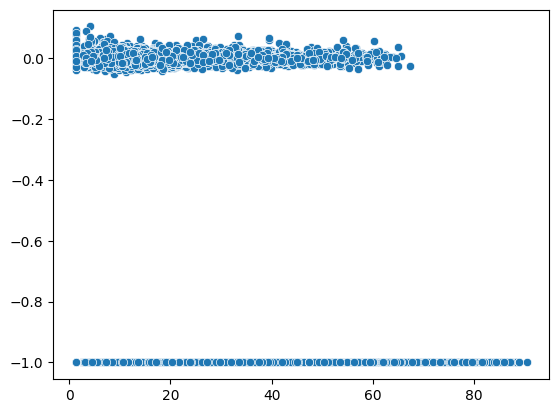

<Axes: >

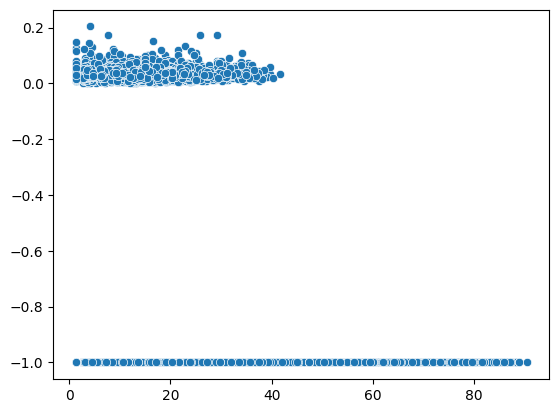

In [58]:
from matplotlib import pyplot as plt
sns.scatterplot(x=plm_dist_score[:,0],y=plm_dist_score[:,1])
plt.show()
sns.scatterplot(x=mf_dist_score[:,0],y=mf_dist_score[:,1])

In [50]:
pairwise_dists_and_plm

{(1, 0): {'dist': 1.3322872, 'score': -0.0041105805347562},
 (2, 0): {'dist': 3.4894183, 'score': 0.0201634912614309},
 (2, 1): {'dist': 1.3290927, 'score': 0.0273590978409769},
 (3, 0): {'dist': 6.7644925, 'score': -0.0114971836061014},
 (3, 1): {'dist': 4.7313166, 'score': 0.0021449367150518},
 (3, 2): {'dist': 1.3302827, 'score': -0.0027454259080771},
 (4, 0): {'dist': 8.981501, 'score': 0.000243250336427},
 (4, 1): {'dist': 7.5606728, 'score': -0.0274165285037461},
 (4, 2): {'dist': 3.8433883, 'score': 0.0019811225150754},
 (4, 3): {'dist': 1.354358, 'score': -0.0015906578798514},
 (5, 0): {'dist': 11.148689, 'score': 0.0005179429715834},
 (5, 1): {'dist': 10.568974, 'score': -0.0130624856089784},
 (5, 2): {'dist': 7.11493, 'score': -0.0138408377234316},
 (5, 3): {'dist': 3.703096, 'score': -0.0052849127631591},
 (5, 4): {'dist': 1.3461472, 'score': -0.0129384185537965},
 (6, 0): {'dist': 14.242777, 'score': 0.002285193377767},
 (6, 1): {'dist': 12.297987, 'score': -0.0140239609749